In [1]:

import numpy as np
import pandas as pd
from scipy import stats
import torch
import torch.nn as nn
import sys

from scipy.spatial.distance import cdist
import odor_stat_calculations as osc
from scipy.stats import kurtosis
from scipy.stats import norm

import matplotlib.pyplot as plt 
import seaborn as sns
from figurefirst import FigureLayout,mpl_functions
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import wasserstein_distance
import time

from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from gluonts.dataset.pandas import PandasDataset

import os

sys.path.append(os.path.abspath("../lag-llama"))
from lag_llama.gluon.estimator import LagLlamaEstimator

/home/gorilla/An/arunavanag/lib/python3.10/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [145]:
dirname = '../data/simulator/hws/'
hmap_data = np.load(str(dirname) + "hmap_with_edges.npz")
fitted_p_heatmap=hmap_data['fitted_p_heatmap']
fitted_p_heatmap=fitted_p_heatmap
xedges=hmap_data['xedges']
yedges=hmap_data['yedges']
fdf=pd.read_hdf(str(dirname) + 'whiff.h5')
fdf_nowhiff=pd.read_hdf(str(dirname) + 'nowhiff.h5')
fitted_p_heatmap_1=fitted_p_heatmap

def moving_average(data, window_size):
    if window_size < 1 or len(data) < window_size:
        return data  # Return data as is if the window size is too large for the data length
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(data, window, 'same')



In [146]:
dfres = pd.read_hdf(str(dirname) + 'hwsDesert.h5')

In [147]:
dfres['spatial_prob'] = 0  # Default to 0 for all rows

for i, row in dfres.iterrows():
    dist_along = row['distance_along_streakline']
    nearest_from = row['nearest_from_streakline']
    
    x_bin = np.digitize([dist_along], xedges)[0] - 1
    y_bin = np.digitize([nearest_from], yedges)[0] - 1

    if (0 <= x_bin < fitted_p_heatmap_1.shape[0] and 0 <= y_bin < fitted_p_heatmap_1.shape[1]):
        spatial_prob = fitted_p_heatmap_1[x_bin, y_bin]
    else:
        spatial_prob = 0  # Default to 0 if outside bounds

    # Assign the spatial probability to the new column
    dfres.at[i, 'spatial_prob'] = spatial_prob


whiff_indices = dfres[dfres['whiff_flag'] == 1].index
time_since_last_whiff_array = np.zeros(len(dfres))

for i in range(1, len(whiff_indices)):
    start = whiff_indices[i - 1]
    end = whiff_indices[i]

    # Assign to the correct range excluding the 'end' index
    time_since_last_whiff_array[start:end] = (
        dfres.loc[start:end - 1, 'time'].values - dfres.loc[start, 'time']
    )
dfres['inter_whiff_time']=time_since_last_whiff_array


In [249]:
df_test = dfres[10000:20000].reset_index(drop=True)
dt=df_test.master_time[1]-df_test.master_time[0]
time = []
time.append(0)
for i in range(1,len(df_test)):
    time.append(time[i-1]+dt)
    
df_test['time'] = time


distance_threshold = 2
rows_per_second = 200
base_odor_level = 0.58 

odor_concentration_samples = np.full(len(df_test), base_odor_level)
whiff_prediction_samples = np.zeros(len(df_test), dtype=int)

test_locations = df_test[['distance_along_streakline', 'nearest_from_streakline']].values
whiff_locations = fdf[['avg_distance_along_streakline', 'avg_nearest_from_streakline']].values
nowhiff_locations = fdf_nowhiff[['avg_distance_along_streakline', 'avg_nearest_from_streakline']].values

whiff_means = fdf.mean_concentration.values
whiff_stds = fdf.std_whiff.values
whiff_duration = fdf.length_of_encounter.values
nowhiff_means = fdf_nowhiff.wc_nowhiff.values
nowhiff_wsd = fdf_nowhiff.wsd_nowhiff.values
whiff_intermittency=fdf.odor_intermittency.values
distances = cdist(test_locations, whiff_locations)
distances_nowhiff = cdist(test_locations,nowhiff_locations )


In [250]:
# def moving_average(data, window_size):
#     if window_size < 1 or len(data) < window_size:
#         return data
#     window = np.ones(int(window_size)) / float(window_size)
#     return np.convolve(data, window, 'same')

# class DynamicRNN(nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim, use_attention=True):
#         super(DynamicRNN, self).__init__()
#         self.hidden_dim = hidden_dim
#         self.use_attention = use_attention

#         self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
#         if use_attention:
#             self.attention = nn.Linear(hidden_dim, 1)  # Attention weights for timesteps
#         self.fc = nn.Linear(hidden_dim, output_dim)
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x, hidden_state=None):
#         lstm_out, hidden_state = self.lstm(x, hidden_state)
#         if self.use_attention:
#             attention_weights = torch.softmax(self.attention(lstm_out), dim=1)
#             lstm_out = (lstm_out * attention_weights).sum(dim=1)  # Weighted sum
#         else:
#             lstm_out = lstm_out[:, -1, :]  # Last time step
#         out = self.fc(lstm_out)
#         return self.sigmoid(out), hidden_state

# # Initialize Model
# input_dim = 5  # Updated input dimension to include previous whiff flag
# hidden_dim = 64
# output_dim = 1
# use_attention = True

# rnn_model = DynamicRNN(input_dim, hidden_dim, output_dim, use_attention)
# rnn_model.train()

# # Dynamic Variables
# hidden_state = None
# current_time = 0
# last_whiff_time = 0
# previous_whiff_flag = 0
# sequence_buffer = []
# whiff_flag_sequence = []
# sequence_length = 1600  # Sliding window of past rows

# # Placeholder arrays for predictions
# odor_concentration_samples = np.full(len(df_test), base_odor_level)
# whiff_prediction_samples = np.zeros(len(df_test), dtype=int)

# alpha = 1  # Scaling factor for distance effect
# max_distance = df_test['distance_along_streakline'].max()

# # Loss and Optimizer
# loss_function = nn.BCELoss()  # Binary Cross-Entropy for probabilities
# optimizer = torch.optim.Adam(rnn_model.parameters(), lr=0.001)

# # Real-Time Dynamic Prediction
# for i in range(len(df_test)):
#     row = df_test.iloc[i]
#     dist_along, nearest_from = row['distance_along_streakline'], row['nearest_from_streakline']
#     time_since_last_whiff = current_time - last_whiff_time

#     # Calculate Spatial Probability
#     spatial_prob = row['spatial_prob']

#     # Dynamic Feature Vector
#     feature_vector = [dist_along, nearest_from, spatial_prob, time_since_last_whiff, previous_whiff_flag]
#     sequence_buffer.append(feature_vector)
#     if len(sequence_buffer) > sequence_length:
#         sequence_buffer.pop(0)  # Maintain fixed sequence length

#     # Skip if not enough history
#     if len(sequence_buffer) < sequence_length:
#         current_time += dt
#         continue

#     # Prepare input sequence
#     input_sequence = torch.tensor(sequence_buffer, dtype=torch.float32).unsqueeze(0)

#     # Predict dynamically
#     rnn_model.eval()
#     with torch.no_grad():
#         prob, hidden_state = rnn_model(input_sequence, hidden_state)
#         whiff_prob = prob.item()*0.01

#     # Generate Whiff Concentration
#     if np.random.rand() < whiff_prob and np.min(distances[i]) <= distance_threshold:
#         nearest_whiff_idx = np.argmin(distances[i])
#         mean_concentration = whiff_means[nearest_whiff_idx]
#         std_dev_whiff = whiff_stds[nearest_whiff_idx]
#         duration = int(whiff_duration[nearest_whiff_idx] * rows_per_second)
#         rows_to_fill = min(duration, len(df_test) - i)

#         generated_concentrations = np.random.normal(mean_concentration, std_dev_whiff, rows_to_fill)
#         generated_concentrations = np.clip(generated_concentrations, 4.5, 10.2)

#         odor_concentration_samples[i:i + rows_to_fill] = generated_concentrations
#         whiff_prediction_samples[i:i + rows_to_fill] = 1

#         last_whiff_time = current_time
#         current_time += rows_to_fill * dt
#         i += rows_to_fill

#         # Set previous whiff flag to 1
#         previous_whiff_flag = 1
#     else:
#         current_time += dt
#         i += 1

#         previous_whiff_flag = 0

#     # rnn_model.train()
#     # optimizer.zero_grad()
#     # output, _ = rnn_model(input_sequence, hidden_state)
#     # actual_whiff = torch.tensor([row['whiff_flag']], dtype=torch.float32)
#     # loss = loss_function(output.squeeze(-1), actual_whiff)
#     # loss.backward()
#     # optimizer.step()

# # Handle No-Whiff Zones
# for i in range(len(df_test)):
#     if odor_concentration_samples[i] == base_odor_level:
#         nearest_no_whiff_idx = np.argmin(distances_nowhiff[i])
#         no_whiff_mean = nowhiff_means[nearest_no_whiff_idx]
#         no_whiff_std = nowhiff_wsd[nearest_no_whiff_idx]

#         start = i
#         while i < len(df_test) and odor_concentration_samples[i] == base_odor_level:
#             i += 1
#             current_time += dt
#         end = i

#         # Generate concentrations for the no-whiff zone
#         no_whiff_concentrations = np.random.normal(no_whiff_mean, no_whiff_std, end - start)
#         no_whiff_concentrations = np.clip(no_whiff_concentrations, 0, 1)
#         smoothed_concentrations = moving_average(no_whiff_concentrations, window_size=5)
#         odor_concentration_samples[start:end] = smoothed_concentrations

# # Update DataFrame with results
# df_test['predicted_odor'] = odor_concentration_samples
# df_test['whiff_predicted'] = whiff_prediction_samples

In [251]:
# f,(ax1,ax2)= plt.subplots(2,1,figsize=(6,4))
# ax1.plot(df_test.time, df_test.odor, label='original')
# # plt.plot(df_test.smoothed_odor, label='smoothed')
# ax2.plot(df_test.time, df_test.predicted_odor, label='predicted')
# # ax2.axhline(4, color = 'r', linestyle = '--')

# # limit=(40,60)
# # # limit = (1200,1230)
# # ax1.set_xlim(limit)
# # ax2.set_xlim(limit)
# # ax2.set_ylim(0,1)

# ax2.set_ylabel('odor, a.u.')
# ax2.set_xlabel('time,s')
# ax1.set_title('Original Odor')
# ax2.set_title('Predicted Odor')
# f.tight_layout()

In [252]:
# import torchsde
# class SDEFunc(nn.Module):
#     noise_type = "diagonal"  # Specify the noise type: "diagonal", "scalar", or "general"
#     sde_type = "ito" 
#     def __init__(self, input_dim, hidden_dim):
#         super(SDEFunc, self).__init__()
#         # Drift and diffusion networks
#         self.drifts = nn.Sequential(nn.Linear(input_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, input_dim))
#         self.diffusions = nn.Sequential(nn.Linear(input_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, input_dim))

#     def f(self, t, y):  # Drift function
#         return self.drifts(y)

#     def g(self, t, y):  # Diffusion function (stochastic part)
#         return self.diffusions(y)


# class NeuralSDE(nn.Module):
#     def __init__(self, input_dim, hidden_dim):
#         super(NeuralSDE, self).__init__()
#         self.sde_func = SDEFunc(input_dim, hidden_dim)
#         self.initial = nn.Linear(input_dim, hidden_dim)
#         self.readout = nn.Linear(input_dim, 1)  # Use input_dim if the tensor has 4 features
        
#         self.sigmoid = nn.Sigmoid()  # To constrain output between 0 and 1
#         self.dropout = nn.Dropout(p=0.2)
#         # Initialize the readout layer
#         nn.init.xavier_uniform_(self.readout.weight)
#         nn.init.zeros_(self.readout.bias)

#     def forward(self, ts, y0):
#         y = torchsde.sdeint(self.sde_func, y0, ts, method='euler')
#         # print("Shape before readout:", y.shape)  
#         y = self.dropout(y)  
#         y = self.readout(y)
#         return self.sigmoid(y)  # Return probabilities between 0 and 1
    

# def moving_average(data, window_size):
#     if window_size < 1 or len(data) < window_size:
#         return data
#     window = np.ones(int(window_size)) / float(window_size)
#     return np.convolve(data, window, 'same')
# thx=15
# valid_intermittency = whiff_intermittency[whiff_intermittency < thx]
# median_intermittency = np.mean(valid_intermittency)
# whiff_intermittency_cleaned = np.where(whiff_intermittency > thx, median_intermittency, whiff_intermittency)
# input_dim = 4  # distance_along_streakline, nearest_from_streakline, spatial_prob, time_since_last_whiff
# hidden_dim = 64
# alpha=1
# max_distance = df_test['distance_along_streakline'].max()
# neural_sde = NeuralSDE(input_dim, hidden_dim)
# neural_sde.train()

# # Optimizer for Neural SDE
# optimizer = torch.optim.Adam(neural_sde.parameters(), lr=0.001, weight_decay=1e-4)

# # Time step initialization
# dt = df_test.master_time[1]-df_test.master_time[0]
# ts = torch.linspace(0, dt, steps=2)  # Time steps for SDE solver
# # ts = torch.tensor([0.0])

# # Updated sequence length for 8 seconds
# sequence_length = 1600  # 8 seconds * 200 rows/second

# # Loop variables
# sequence_buffer = []

# y0 = torch.zeros(input_dim)  # Initial state for the SDE
# current_time = 0
# last_whiff_time = 0

# for i in range(len(df_test)):
#     row = df_test.iloc[i]
#     dist_along, nearest_from = row['distance_along_streakline'], row['nearest_from_streakline']
#     spatial_prob = row['spatial_prob']
#     time_since_last_whiff = current_time - last_whiff_time

#     # Create feature vector
#     feature_vector = torch.tensor([dist_along, nearest_from, spatial_prob, time_since_last_whiff], dtype=torch.float32)
#     sequence_buffer.append(feature_vector)

#     # Maintain a fixed sequence length
#     if len(sequence_buffer) > sequence_length:
#         sequence_buffer.pop(0)

#     # Skip if not enough history
#     if len(sequence_buffer) < sequence_length:
#         current_time += dt
#         continue

#     # Prepare input state
#     y0 = feature_vector.unsqueeze(0)  # Shape: [1, input_dim]

#     # Predict using Neural SDE
#     neural_sde.eval()
#     # with torch.no_grad():
#     #     output = neural_sde(ts, y0)
#     #     pred_whiff_prob = output
#     with torch.no_grad():
#         output = neural_sde(ts, y0)  # Shape: [2, 1, 1]
#         pred_whiff_prob = output[-1].squeeze().item()*0.01 # Extract last time step and convert to scalar
#         print(pred_whiff_prob)
#     # with torch.no_grad():
#     #     pred_whiff_prob = neural_sde(ts, y0).squeeze().item() *0.01 # Get a single scalar prediction
#     #     print(pred_whiff_prob)

#     # Generate whiff concentration based on the predicted probability
#     if np.random.rand() < pred_whiff_prob and np.min(distances[i]) <= distance_threshold:
#         nearest_whiff_idx = np.argmin(distances[i])
#         mean_concentration = whiff_means[nearest_whiff_idx]
#         std_dev_whiff = whiff_stds[nearest_whiff_idx]
#         duration = int(whiff_duration[nearest_whiff_idx] * rows_per_second)
#         rows_to_fill = min(duration, len(df_test) - i)

#         generated_concentrations = np.random.normal(mean_concentration, std_dev_whiff, rows_to_fill)
#         generated_concentrations = np.clip(generated_concentrations, 4.5, 10.2)
#         smoothed_concentrations = moving_average(generated_concentrations, window_size=2)
#         odor_concentration_samples[i:i + rows_to_fill] = smoothed_concentrations
        
#         whiff_prediction_samples[i:i + rows_to_fill] = 1

#         last_whiff_time = current_time
#         current_time += rows_to_fill * dt
#         i += rows_to_fill

#         # Skip intermittency duration
#         base_intermittency_value = whiff_intermittency_cleaned[nearest_whiff_idx]
#         # scaled_intermittency = base_intermittency_value * (0.2 + alpha * (dist_along / max_distance))
#         intermittency_duration = int(base_intermittency_value * rows_per_second)
#         i += intermittency_duration
#     else:
#         current_time += dt
#         i += 1

# # Handle No-Whiff Zones
# i = 0
# while i < len(df_test):
#     if odor_concentration_samples[i] == base_odor_level:
#         # Find the nearest no-whiff location
#         nearest_no_whiff_idx = np.argmin(distances_nowhiff[i])
#         no_whiff_mean = nowhiff_means[nearest_no_whiff_idx]
#         no_whiff_std = nowhiff_wsd[nearest_no_whiff_idx]

#         # Identify the start of the no-whiff zone
#         start = i
#         while i < len(df_test) and odor_concentration_samples[i] == base_odor_level:
#             i += 1
#         end = i

#         # Generate concentrations for the no-whiff zone
#         no_whiff_concentrations = np.random.normal(no_whiff_mean, no_whiff_std, end - start)
#         no_whiff_concentrations = np.clip(no_whiff_concentrations, 0.58, 1)  # Ensure values are within realistic bounds

#         # Apply moving average smoothing
#         smoothed_concentrations = moving_average(no_whiff_concentrations, window_size=5)

#         # Update the odor concentration samples
#         odor_concentration_samples[start:end] = smoothed_concentrations
#     else:
#         i += 1

# # Update DataFrame with results
# df_test['predicted_odor'] = odor_concentration_samples
# df_test['whiff_predicted'] = whiff_prediction_samples



In [253]:
# import gc

# # Set CUDA environment variables
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# os.environ['TORCH_USE_CUDA_DSA'] = '1'

# def clean_gpu_memory():
#     """Clean up GPU memory"""
#     if torch.cuda.is_available():
#         torch.cuda.empty_cache()
#         gc.collect()

# def moving_average(data, window_size):
#     """Apply moving average smoothing"""
#     if window_size < 1 or len(data) < window_size:
#         return data
#     window = np.ones(int(window_size)) / float(window_size)
#     return np.convolve(data, window, 'same')

# def safe_predict(predictor, dataset, device):
#     """Safe prediction with error handling"""
#     try:
#         if device.type == 'cuda':
#             clean_gpu_memory()
#             torch.cuda.synchronize()
        
#         forecast_it = predictor.predict(dataset, num_samples=5)
#         forecast = list(forecast_it)[-1]
        
#         if device.type == 'cuda':
#             torch.cuda.synchronize()
        
#         return forecast
#     except RuntimeError as e:
#         print(f"Prediction error: {str(e)}")
#         return None

# def prepare_lag_llama_dataset(sequence_buffer, df_test, dt=0.005):
#     """Prepare dataset for Lag Llama inference"""
#     df = pd.DataFrame(sequence_buffer)
    
#     for col in df.columns:
#         df[col] = df[col].astype('float32')
    
#     time_index = pd.date_range(
#         start='2024-01-01',
#         periods=len(df),
#         freq=pd.Timedelta(seconds=dt)
#     )
    
#     df.index = time_index
    
#     # Add whiff_flag as target
#     start_idx = max(0, df_test.index[0])
#     end_idx = min(start_idx + len(df), df_test.index[-1])
#     df['target'] = df_test['whiff_flag'].astype('float32')
    
#     dataset = PandasDataset(
#         df,
#         target='target',
#         feat_dynamic_real=[
#             'distance_along_streakline',
#             'nearest_from_streakline',
#             'spatial_prob',
#             'inter_whiff_time'
#         ],
#         freq=pd.Timedelta(seconds=dt)
#     )
    
#     return dataset

# def initialize_model(ckpt_path, device, force_cpu=False):
#     """Initialize model with proper error handling"""
#     try:
#         ckpt = torch.load(ckpt_path, map_location='cpu')
#         estimator_args = ckpt["hyper_parameters"]["model_kwargs"]
        
#         if force_cpu:
#             device = torch.device('cpu')
        
#         estimator = LagLlamaEstimator(
#             ckpt_path=ckpt_path,
#             prediction_length=1,
#             context_length=800,
#             input_size=estimator_args["input_size"],
#             n_layer=estimator_args["n_layer"],
#             n_embd_per_head=estimator_args["n_embd_per_head"],
#             n_head=estimator_args["n_head"],
#             scaling=estimator_args["scaling"],
#             time_feat=estimator_args["time_feat"],
#             device=device
#         )
        
#         lightning_module = estimator.create_lightning_module()
#         if device.type == 'cuda' and not force_cpu:
#             lightning_module = lightning_module.cuda()
        
#         transformation = estimator.create_transformation()
#         predictor = estimator.create_predictor(transformation, lightning_module)
        
#         return predictor, device
    
#     except Exception as e:
#         print(f"Model initialization error: {str(e)}")
#         if not force_cpu:
#             print("Retrying with CPU...")
#             return initialize_model(ckpt_path, torch.device('cpu'), force_cpu=True)
#         raise

# def run_whiff_prediction_pipeline(df_test, ckpt_path, fdf, fdf_nowhiff, force_cpu=False):
#     """Complete pipeline with robust error handling"""
#     try:
#         # Initialize model and device
#         predictor, device = initialize_model(ckpt_path, 
#                                           torch.device('cpu' if force_cpu else 'cuda'), 
#                                           force_cpu)
        
#         # Parameters
#         rows_per_second = 200
#         base_odor_level = np.float32(0.58)
#         dt = np.float32(0.005)
#         distance_threshold = np.float32(2.0)
#         sequence_length = 800
        
#         # Initialize arrays and variables
#         current_time = np.float32(0.0)
#         last_whiff_time = np.float32(0.0)
#         sequence_buffer = []
#         odor_concentration_samples = np.full(len(df_test), base_odor_level, dtype=np.float32)
#         whiff_prediction_samples = np.zeros(len(df_test), dtype=np.int32)
#         alpha = np.float32(1.0)
#         max_distance = np.float32(df_test['distance_along_streakline'].max())
        
#         # Prepare distances
#         test_locations = df_test[['distance_along_streakline', 'nearest_from_streakline']].values.astype(np.float32)
#         whiff_locations = fdf[['avg_distance_along_streakline', 'avg_nearest_from_streakline']].values.astype(np.float32)
#         nowhiff_locations = fdf_nowhiff[['avg_distance_along_streakline', 'avg_nearest_from_streakline']].values.astype(np.float32)
        
#         distances = cdist(test_locations, whiff_locations).astype(np.float32)
#         distances_nowhiff = cdist(test_locations, nowhiff_locations).astype(np.float32)
        
#         # Extract parameters
#         whiff_means = fdf.mean_concentration.values.astype(np.float32)
#         whiff_stds = fdf.std_whiff.values.astype(np.float32)
#         whiff_duration = fdf.length_of_encounter.values.astype(np.float32)
#         whiff_intermittency = fdf.odor_intermittency.values.astype(np.float32)
#         nowhiff_means = fdf_nowhiff.wc_nowhiff.values.astype(np.float32)
#         nowhiff_wsd = fdf_nowhiff.wsd_nowhiff.values.astype(np.float32)
        
#         # Clean intermittency values
#         thx = np.float32(15.0)
#         valid_intermittency = whiff_intermittency[whiff_intermittency < thx]
#         median_intermittency = np.float32(np.mean(valid_intermittency))
#         whiff_intermittency_cleaned = np.where(whiff_intermittency > thx, median_intermittency, whiff_intermittency)
        
#         # Prediction loop
#         i = 0
#         consecutive_errors = 0
#         while i < len(df_test):
#             if i % 100 == 0:  # Periodic cleanup
#                 clean_gpu_memory()
            
#             row = df_test.iloc[i]
#             dist_along = np.float32(row['distance_along_streakline'])
#             nearest_from = np.float32(row['nearest_from_streakline'])
#             time_since_last_whiff = np.float32(current_time - last_whiff_time)
            
#             feature_vector = {
#                 'distance_along_streakline': dist_along,
#                 'nearest_from_streakline': nearest_from,
#                 'spatial_prob': np.float32(row['spatial_prob']),
#                 'inter_whiff_time': time_since_last_whiff
#             }
            
#             sequence_buffer.append(feature_vector)
#             if len(sequence_buffer) > sequence_length:
#                 sequence_buffer.pop(0)
            
#             if len(sequence_buffer) < sequence_length:
#                 current_time += dt
#                 i += 1
#                 continue
            
#             try:
#                 pred_dataset = prepare_lag_llama_dataset(sequence_buffer, df_test, dt)
#                 forecast = safe_predict(predictor, pred_dataset, device)
                
#                 if forecast is None:
#                     consecutive_errors += 1
#                     if consecutive_errors > 5 and device.type == 'cuda':
#                         print("Too many errors, switching to CPU...")
#                         predictor, device = initialize_model(ckpt_path, torch.device('cpu'), force_cpu=True)
#                     current_time += dt
#                     i += 1
#                     continue
                
#                 consecutive_errors = 0
#                 whiff_prob = np.float32(forecast.samples.mean(axis=0)[0])
#                 print(f"Index {i}, Whiff probability: {whiff_prob}")
#                 whiff_prob = np.clip(whiff_prob / 10.0, 0, 1)
                
#                 if np.random.rand() < whiff_prob and np.min(distances[i]) <= distance_threshold:
#                     print('True')
#                     nearest_whiff_idx = np.argmin(distances[i])
#                     mean_concentration = whiff_means[nearest_whiff_idx]
#                     std_dev_whiff = whiff_stds[nearest_whiff_idx]
#                     duration = int(whiff_duration[nearest_whiff_idx] * rows_per_second)
#                     rows_to_fill = min(duration, len(df_test) - i)
                    
#                     generated_concentrations = np.random.normal(mean_concentration, std_dev_whiff, rows_to_fill).astype(np.float32)
#                     generated_concentrations = np.clip(generated_concentrations, 4.5, 10.2)
#                     smoothed_concentrations = moving_average(generated_concentrations, window_size=2)
                    
#                     odor_concentration_samples[i:i + rows_to_fill] = smoothed_concentrations
#                     whiff_prediction_samples[i:i + rows_to_fill] = 1
                    
#                     last_whiff_time = current_time
#                     current_time += duration * dt
#                     i += rows_to_fill
                    
#                     base_intermittency_value = whiff_intermittency_cleaned[nearest_whiff_idx]
#                     scaled_intermittency = base_intermittency_value * (0.2 + alpha * (dist_along / max_distance))
#                     intermittency_duration = int(scaled_intermittency * rows_per_second)
#                     i += intermittency_duration
#                 else:
#                     current_time += dt
#                     i += 1
                
#             except Exception as e:
#                 print(f"Error at index {i}: {str(e)}")
#                 if device.type == 'cuda':
#                     print("Switching to CPU due to error...")
#                     predictor, device = initialize_model(ckpt_path, torch.device('cpu'), force_cpu=True)
#                 current_time += dt
#                 i += 1
        
#         # Handle No-Whiff Zones
#         i = 0
#         while i < len(df_test):
#             if odor_concentration_samples[i] == base_odor_level:
#                 nearest_no_whiff_idx = np.argmin(distances_nowhiff[i])
#                 no_whiff_mean = nowhiff_means[nearest_no_whiff_idx]
#                 no_whiff_std = nowhiff_wsd[nearest_no_whiff_idx]
                
#                 start = i
#                 while i < len(df_test) and odor_concentration_samples[i] == base_odor_level:
#                     i += 1
#                 end = i
                
#                 no_whiff_concentrations = np.random.normal(no_whiff_mean, no_whiff_std, end - start).astype(np.float32)
#                 no_whiff_concentrations = np.clip(no_whiff_concentrations, 0.58, 1)
#                 smoothed_concentrations = moving_average(no_whiff_concentrations, window_size=5)
#                 odor_concentration_samples[start:end] = smoothed_concentrations
#             else:
#                 i += 1
        
#         df_test['predicted_odor'] = odor_concentration_samples
#         df_test['whiff_predicted'] = whiff_prediction_samples
        
#         return df_test
        
#     except Exception as e:
#         print(f"Pipeline error: {str(e)}")
#         if not force_cpu:
#             print("Retrying with CPU...")
#             return run_whiff_prediction_pipeline(df_test, ckpt_path, fdf, fdf_nowhiff, force_cpu=True)
#         raise

# # Example usage
# ckpt_path = "/home/gorilla/An/lag-llama/lag-llama.ckpt"
# df_test = run_whiff_prediction_pipeline(
#     df_test=df_test,
#     ckpt_path=ckpt_path,
#     fdf=fdf,
#     fdf_nowhiff=fdf_nowhiff,
#     force_cpu=False
# )



In [254]:
from torch.nn.utils import weight_norm

# Moving average smoothing function
def moving_average(data, window_size):
    if window_size < 1 or len(data) < window_size:
        return data
    window = np.ones(int(window_size)) / float(window_size)
    return np.convolve(data, window, 'same')

from collections import deque
thx=25
valid_intermittency = whiff_intermittency[whiff_intermittency < thx]
median_intermittency = np.mean(valid_intermittency)
whiff_intermittency_cleaned = np.where(whiff_intermittency > thx, median_intermittency, whiff_intermittency)


# TCN Block Definition
class TCNBlock(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_size, dilation, dropout):
        super(TCNBlock, self).__init__()
        padding = (kernel_size - 1) * dilation
        self.conv = nn.Conv1d(input_dim, output_dim, kernel_size, padding=padding, dilation=dilation)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.residual = nn.Conv1d(input_dim, output_dim, 1)

    def forward(self, x):
        out = self.conv(x)
        out = out[:, :, :x.size(2)]  # Trim to match input length
        out = self.relu(out)
        out = self.dropout(out)
        return out + self.residual(x)

# TCN Model Definition
class TCN(nn.Module):
    def __init__(self, input_dim, output_dim, num_channels, kernel_size=3, dropout=0.2):
        super(TCN, self).__init__()
        layers = []
        for i in range(len(num_channels)):
            dilation = 2 ** i
            in_channels = input_dim if i == 0 else num_channels[i - 1]
            out_channels = num_channels[i]
            layers.append(TCNBlock(in_channels, out_channels, kernel_size, dilation, dropout))
        self.network = nn.Sequential(*layers)
        self.fc = nn.Linear(num_channels[-1], output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.transpose(1, 2)  # (batch_size, input_dim, seq_length)
        out = self.network(x)
        out = out[:, :, -1]  # Take the last time step
        out = self.fc(out)
        return self.sigmoid(out)

# Initialize TCN Model
input_dim = 5  # Including previous whiff flag
hidden_channels = [32, 32, 64]
output_dim = 1
kernel_size = 3
dropout = 0.2

tcn_model = TCN(input_dim, output_dim, hidden_channels, kernel_size, dropout)
tcn_model.eval()  # No training, just inference

# Dynamic Variables
sequence_length = 1600
sequence_buffer = deque(maxlen=sequence_length)
posterior_probabilities = []

alpha = 0.002         
max_distance = df_test['distance_along_streakline'].max()
base_odor_level = 0.58
last_whiff_time = 0

# Placeholder arrays
odor_concentration_samples = np.full(len(df_test), base_odor_level)
whiff_prediction_samples = np.zeros(len(df_test), dtype=int)

# Parameters
prob_smoothing_window = 100  # Adjust the window size for smoothing

# Track whiff probabilities
smoothed_probs = []

# Main Loop
for i in range(len(df_test)):
    row = df_test.iloc[i]
    dist_along = row['distance_along_streakline']
    nearest_from = row['nearest_from_streakline']
    spatial_prob = row['spatial_prob']
    current_time = row['time']
    time_since_last_whiff = current_time - last_whiff_time if last_whiff_time else 0
    previous_whiff_flag = whiff_prediction_samples[i - 1] if i > 0 else 0

    # Update sequence buffer
    feature_vector = [dist_along, nearest_from, spatial_prob, time_since_last_whiff, previous_whiff_flag]
    sequence_buffer.append(feature_vector)

    # Skip if not enough history
    if len(sequence_buffer) < sequence_length:
        continue

    # Prepare input for TCN
    input_sequence = torch.tensor(sequence_buffer, dtype=torch.float32).unsqueeze(0)

    # Predict temporal probability
    with torch.no_grad():
        temporal_prob = tcn_model(input_sequence).item()

    # Combine temporal and spatial probabilities
    combined_prob = alpha * temporal_prob + (1 - alpha) * spatial_prob
    
    smoothed_probs.append(combined_prob)
    if len(smoothed_probs) > prob_smoothing_window:
        smoothed_probs = smoothed_probs[-prob_smoothing_window:]
    
    smoothed_prob = np.mean(smoothed_probs)

    # Predict whiff
    whiff_predicted = 1 if np.random.random() < smoothed_prob  else 0
    whiff_prediction_samples[i] = whiff_predicted
    posterior_probabilities.append(combined_prob)
    # print(combined_prob)
    # print('sp=',smoothed_prob)
    # Update odor concentration for whiff predictions
    if whiff_predicted:
        nearest_whiff_idx = np.argmin(distances[i])
        mean_concentration = whiff_means[nearest_whiff_idx]
        std_dev_whiff = whiff_stds[nearest_whiff_idx]
        duration = int(whiff_duration[nearest_whiff_idx] * rows_per_second)
        rows_to_fill = min(duration, len(df_test) - i)

        generated_concentrations = np.random.normal(mean_concentration, std_dev_whiff, rows_to_fill)
        generated_concentrations = np.clip(generated_concentrations, 4.5, 10.2)

        odor_concentration_samples[i:i + rows_to_fill] = generated_concentrations
        whiff_prediction_samples[i:i + rows_to_fill] = 1

        last_whiff_time = current_time
        current_time += rows_to_fill * dt
        i += rows_to_fill
        base_intermittency = whiff_intermittency[nearest_whiff_idx]
        # scaled_intermittency = base_intermittency * (0.2 + alpha * (dist_along / max_distance))
        # scaled_intermittency = base_intermittency * (0.2 + alpha * (1 - (dist_along / max_distance)))

        intermittency_duration = int(base_intermittency * rows_per_second)
        i += intermittency_duration
        # Set previous whiff flag to 1
        previous_whiff_flag = 1
    else:
        current_time += dt
        i += 1

        previous_whiff_flag = 0

# Handle No-Whiff Zones
for i in range(len(df_test)):
    if odor_concentration_samples[i] == base_odor_level:
        nearest_no_whiff_idx = np.argmin(distances_nowhiff[i])
        no_whiff_mean = nowhiff_means[nearest_no_whiff_idx]
        no_whiff_std = nowhiff_wsd[nearest_no_whiff_idx]

        start = i
        while i < len(df_test) and odor_concentration_samples[i] == base_odor_level:
            i += 1
            current_time += dt
        end = i

        # Generate concentrations for the no-whiff zone
        no_whiff_concentrations = np.random.normal(no_whiff_mean, no_whiff_std, end - start)
        no_whiff_concentrations = np.clip(no_whiff_concentrations, 0, 1)
        smoothed_concentrations = moving_average(no_whiff_concentrations, window_size=5)
        odor_concentration_samples[start:end] = smoothed_concentrations

# Update DataFrame with results
df_test['predicted_odor'] = odor_concentration_samples
df_test['whiff_predicted'] = whiff_prediction_samples

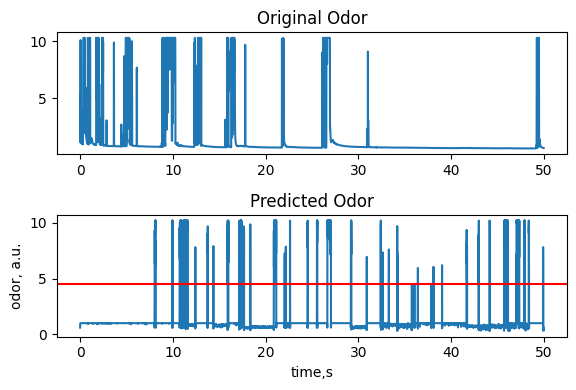

In [255]:
f,(ax1,ax2)= plt.subplots(2,1,figsize=(6,4))
ax1.plot(df_test.time, df_test.odor, label='original')
# plt.plot(df_test.smoothed_odor, label='smoothed')
ax2.plot(df_test.time, df_test.predicted_odor, label='predicted')
# ax2.axhline(4, color = 'r', linestyle = '--')

limit=(14,20)
# # limit = (1200,1230)
# ax1.set_xlim(limit)
# ax2.set_xlim(limit)
# ax2.set_ylim(0,1)
ax2.axhline(4.5, c='r')
ax2.set_ylabel('odor, a.u.')
ax2.set_xlabel('time,s')
ax1.set_title('Original Odor')
ax2.set_title('Predicted Odor')
f.tight_layout()

In [256]:
th=4.5
query1 = 'odor>4.5'
new_test_df1 = df_test.query(query1)
new_test_df1.reset_index(inplace=True, drop=True)

query2 = 'predicted_odor>4.5'
new_test_df2 = df_test.query(query2)
new_test_df2.reset_index(inplace=True, drop=True)


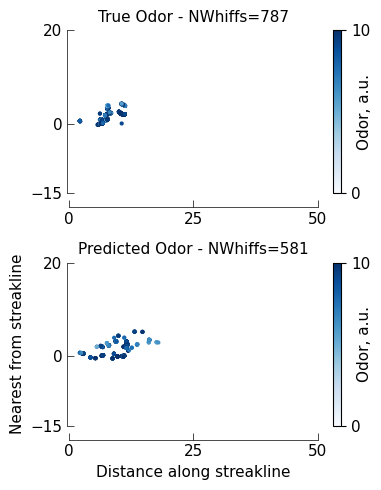

In [257]:

f, ax = plt.subplots(2, 1, figsize=(4, 5))

cax1 = ax[0].scatter(new_test_df1.distance_along_streakline, new_test_df1.nearest_from_streakline, c=new_test_df1.odor, s = 4, cmap='Blues', vmin=0, vmax=10)
cax2 = ax[1].scatter(new_test_df2.distance_along_streakline, new_test_df2.nearest_from_streakline, c=new_test_df2.predicted_odor, s = 4, cmap='Blues', vmin=0, vmax=10)
# cax3 = ax[2].scatter(new_test_df2.distance_along_streakline, new_test_df2.nearest_from_streakline, c=new_test_df2.whiff_predicted, s = 4, cmap='Blues', vmin=0, vmax=1)


# ylim=(-15,25)

ax[0].set_title('True Odor - NWhiffs='+str(len(new_test_df1)))
ax[1].set_title('Predicted Odor - NWhiffs='+str(len(new_test_df2)))

ax[1].set_xlabel('Distance along streakline')
ax[1].set_ylabel('Nearest from streakline')

cb1=plt.colorbar(cax1)
cb2=plt.colorbar(cax2)
# cb3=plt.colorbar(cax3)

cb1.set_label('Odor, a.u.',labelpad=-10)
cb2.set_label('Odor, a.u.',labelpad=-10)
# cb3.set_label('P(Whiff Onset)',labelpad=-10)5

cb1.set_ticks([0,10])
cb2.set_ticks([0,10])
# cb3.set_ticks([0, 1])
for i in range(2):
    mpl_functions.adjust_spines(ax[i],['left','bottom'],
                            spine_locations={'left': 1}, 
                            smart_bounds=True,
                            xticks=[0,25,50],
                            yticks=[-15,0,20],
                            linewidth=0.5)
    mpl_functions.set_fontsize(ax[i],11)

f.tight_layout()

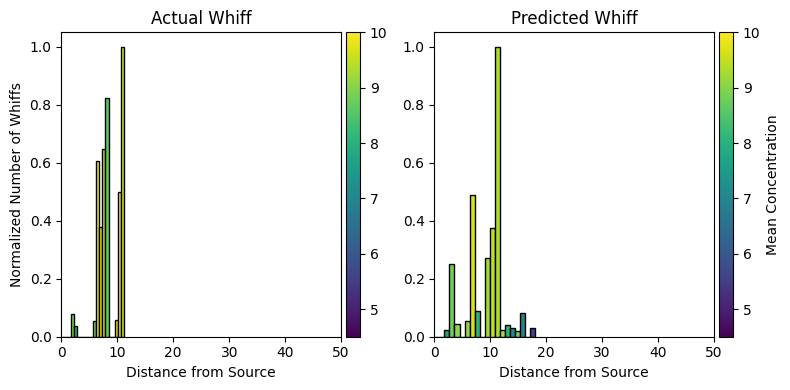

In [258]:
n_bins = 20

# Actual Whiff Data
df_actual = new_test_df1.copy()
bins = np.linspace(0, df_actual['distance_from_source'].max(), n_bins + 1)
df_actual['distance_bin'] = pd.cut(df_actual['distance_from_source'], bins=bins)

whiff_counts_actual = df_actual.groupby('distance_bin').size()
mean_concentrations_actual = df_actual.groupby('distance_bin')['odor'].mean()
bin_centers_actual = (bins[:-1] + bins[1:]) / 2

# Normalize actual whiff counts5
whiff_counts_actual_norm = whiff_counts_actual / whiff_counts_actual.max()

# Predicted Whiff Data
df_predicted = new_test_df2.copy()
bins_predicted = np.linspace(0, df_predicted['distance_from_source'].max(), n_bins + 1)
df_predicted['distance_bin'] = pd.cut(df_predicted['distance_from_source'], bins=bins_predicted)

whiff_counts_predicted = df_predicted.groupby('distance_bin').size()
mean_concentrations_predicted = df_predicted.groupby('distance_bin')['predicted_odor'].mean()
bin_centers_predicted = (bins_predicted[:-1] + bins_predicted[1:]) / 2

# Normalize predicted whiff counts
whiff_counts_predicted_norm = whiff_counts_predicted / whiff_counts_predicted.max()

# Create the subplots
f, ax = plt.subplots(1, 2, figsize=(8, 4))

# Plot for Actual Whiff Data
norm_actual = plt.Normalize(4.5, 10)
colors_actual = plt.cm.viridis(norm_actual(mean_concentrations_actual))
bars_actual = ax[0].bar(bin_centers_actual, whiff_counts_actual_norm, width=(bins[1] - bins[0]), edgecolor='black', color=colors_actual)

divider_actual = make_axes_locatable(ax[0])
cax_actual = divider_actual.append_axes("right", size="5%", pad=0.05)
sm_actual = plt.cm.ScalarMappable(cmap='viridis', norm=norm_actual)
sm_actual.set_array([])
cbar_actual = plt.colorbar(sm_actual, cax=cax_actual)

ax[0].set_xlabel('Distance from Source')
ax[0].set_ylabel('Normalized Number of Whiffs')
ax[0].set_title('Actual Whiff')
# ax[0].set_ylim(0, 1)
ax[0].set_xlim(0, 50)

# Plot for Predicted Whiff Data
norm_predicted = plt.Normalize(4.5, 10)
colors_predicted = plt.cm.viridis(norm_predicted(mean_concentrations_predicted))
bars_predicted = ax[1].bar(bin_centers_predicted, whiff_counts_predicted_norm, width=(bins_predicted[1] - bins_predicted[0]), edgecolor='black', color=colors_predicted)

divider_predicted = make_axes_locatable(ax[1])
cax_predicted = divider_predicted.append_axes("right", size="5%", pad=0.05)
sm_predicted = plt.cm.ScalarMappable(cmap='viridis', norm=norm_predicted)
sm_predicted.set_array([])
cbar_predicted = plt.colorbar(sm_predicted, cax=cax_predicted)
cbar_predicted.set_label('Mean Concentration')

ax[1].set_xlabel('Distance from Source')
ax[1].set_title('Predicted Whiff')
# ax[1].set_ylim(0, 1)
ax[1].set_xlim(0, 50)

f.tight_layout()



In [259]:
new_test_df1=df_test.copy()
new_test_df2=df_test.copy()

def cal_stat(df,idx,df2):
    osc.avg_distance(df,idx,df2)
    osc.mean_conc(df,idx,df2)
    osc.whiff_blank_duration(df,idx,df2)
    osc.std_whiff(df,idx,df2)
    osc.mean_avg(df,idx,df2)
    osc.encounter_frequency(df,idx,df2,1,2)
    osc.mean_t(df,idx,df2)

def cal_stat_predicted(df,idx,df2):
    osc.avg_distance(df,idx,df2)
    osc.predicted_mean_conc(df,idx,df2)
    osc.whiff_blank_duration(df,idx,df2)
    osc.std_whiff_predicted(df,idx,df2)
    osc.mean_avg_predicted(df,idx,df2)
    osc.encounter_frequency_predicted(df,idx,df2,1,2)
    osc.mean_t(df,idx,df2)
th = 4.5
np.seterr(divide='ignore')
index = osc.get_index(new_test_df1.odor,th)
index_predicted = osc.get_index(new_test_df2.predicted_odor,th)
fdf1 = pd.DataFrame()
fdf_predicted = pd.DataFrame()

cal_stat(new_test_df1,index,fdf1)
cal_stat_predicted(new_test_df2,index_predicted, fdf_predicted)

fdf1.keys()

/home/gorilla/An/plume_sim/odor_stat_calculations.py:228: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.efreq.iloc[start] = 1


Index(['avg_dist_from_source', 'log_avg_dist_from_source',
       'mean_concentration', 'length_of_encounter', 'odor_intermittency',
       'log_whiff', 'log_blank', 'std_whiff', 'whiff_ma', 'wf', 'mean_time'],
      dtype='object')

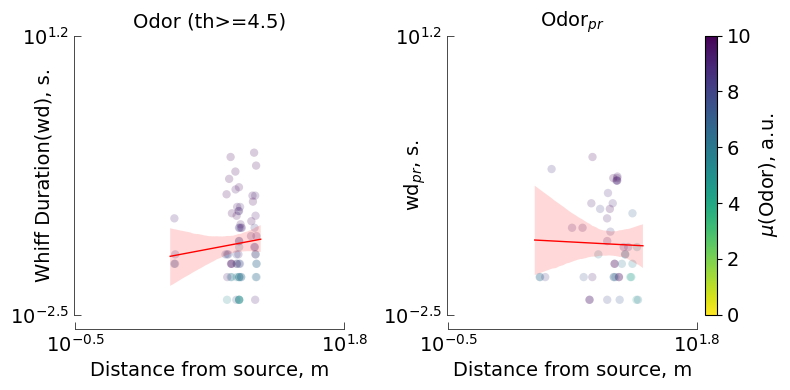

In [260]:
### WHIFF DURATION
f,(ax1,ax2)=plt.subplots(1,2,figsize=(8,4))
var = ax1.scatter(fdf1.log_avg_dist_from_source,fdf1.log_whiff, c=fdf1.mean_concentration, cmap='viridis_r',edgecolors='none', 
                 alpha=0.2,vmin=0,vmax=10  )
ax1.set_ylabel('$\mu$(WC), a.u.')

g1 = sns.regplot(x=fdf1.log_avg_dist_from_source,y=fdf1.log_whiff , data=fdf1,
            ax=ax1, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)

# divider = make_axes_locatable(ax1)
# cax = divider.append_axes('right', size='5%', pad=0.08)
# cbar=f.colorbar(var, cax=cax, orientation = 'vertical')
# cbar.solids.set(alpha=1)
# cbar.set_label('$\mu$(WC), a.u.')

ax1.set_xlabel('Distance from source, m')
ax1.set_ylabel('Whiff Duration(wd), s.')
ax1.set_title('Odor (th>='+str(th)+')')
ax1.yaxis.set_label_coords(-0.08, 0.5)

u=ax2.scatter(fdf_predicted.log_avg_dist_from_source,
              fdf_predicted.log_whiff, 
              c=fdf_predicted.mean_concentration, cmap='viridis_r',edgecolors='none', 
                 alpha=0.2, vmin=0,vmax=10)

g2 = sns.regplot(x=fdf_predicted.log_avg_dist_from_source,y=fdf_predicted.log_whiff , data=fdf_predicted,
            ax=ax2, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(u, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(Odor), a.u.')

ax2.set_xlabel('Distance from source, m')
ax2.set_title('Odor$_{pr}$')
ax2.set_ylabel('wd$_{pr}$, s.')
ax2.yaxis.set_label_coords(-0.08, 0.5)
mpl_functions.adjust_spines(ax1,['left','bottom'],
                            spine_locations={'left': 1}, 
                            smart_bounds=True,
                            xticks=[-0.5,1.8],
                            yticks=[-2.5,1.2],
                            linewidth=0.5)
mpl_functions.adjust_spines(ax2,['left','bottom'],
                            spine_locations={'left': 1}, 
                            smart_bounds=True,
                            xticks=[-0.5,1.8],
                            yticks=[-2.5,1.2],
                            linewidth=0.5)
ax1.set_yticklabels([r'$10^{-2.5}$',r'$10^{1.2}$'])
ax1.set_xticklabels([r'$10^{-0.5}$',r'$10^{1.8}$'])
ax2.set_yticklabels([r'$10^{-2.5}$',r'$10^{1.2}$'])
ax2.set_xticklabels([r'$10^{-0.5}$',r'$10^{1.8}$'])

mpl_functions.set_fontsize(f, 14)
f.tight_layout()


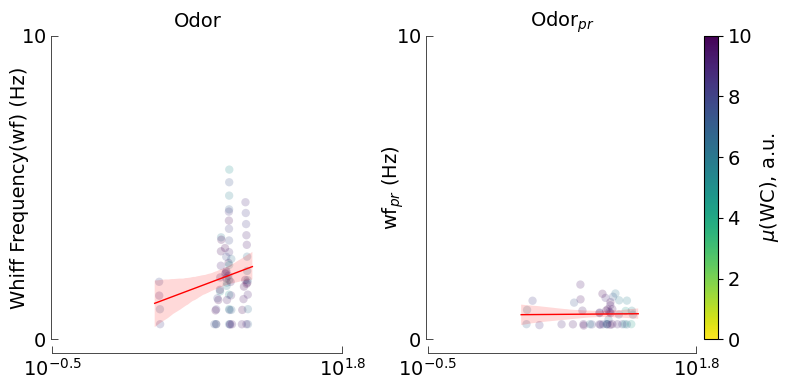

In [261]:
### WHIFF FREQUENCY5
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# Plot for actual odor
var = ax1.scatter(fdf1.log_avg_dist_from_source, fdf1.wf, c=fdf1.mean_concentration, cmap='viridis_r', edgecolors='none',
                  alpha=0.2, vmin=0, vmax=10)
ax1.set_ylabel('Whiff Frequency (Hz)')

g1 = sns.regplot(x=fdf1.log_avg_dist_from_source, y=fdf1.wf, data=fdf1,
                 ax=ax1, line_kws={'color': 'red', 'linewidth': 1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)
ax1.set_ylim(0,)
ax1.set_title('Odor')

# Plot for predicted odor
u = ax2.scatter(fdf_predicted.log_avg_dist_from_source, fdf_predicted.wf, c=fdf_predicted.mean_concentration,
                cmap='viridis_r', edgecolors='none', alpha=0.2, vmin=0, vmax=10)

g2 = sns.regplot(x=fdf_predicted.log_avg_dist_from_source, y=fdf_predicted.wf, data=fdf_predicted,
                 ax=ax2, line_kws={'color': 'red', 'linewidth': 1}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)

# Add color bar only for the predicted odor plot
divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1 = f.colorbar(u, cax=cax1, orientation='vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC), a.u.')

# Set the titles and labels
ax2.set_title('Odor$_{pr}$')
ax1.yaxis.set_label_coords(-0.08, 0.5)
ax2.yaxis.set_label_coords(-0.08, 0.5)
ax1.set_ylabel('Whiff Frequency(wf) (Hz)')
ax2.set_ylabel('wf$_{pr}$ (Hz)')

# Adjust spines for both plots
mpl_functions.adjust_spines(ax1, ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[-0.5, 1.8],
                            yticks=[0, 10],                                    
                            linewidth=0.5)
mpl_functions.adjust_spines(ax2, ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[-0.5, 1.8],
                            yticks=[0, 10],
                            linewidth=0.5)

ax1.set_ylim(0,)

# Set custom tick labels
ax1.set_yticklabels([r'$0$', r'$10$'])
ax1.set_xticklabels([r'$10^{-0.5}$', r'$10^{1.8}$'])
ax2.set_yticklabels([r'$0$', r'$10$'])
ax2.set_xticklabels([r'$10^{-0.5}$', r'$10^{1.8}$'])

# Set font size and layout
mpl_functions.set_fontsize(f, 14)
f.tight_layout()